In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
device = torch.device(f"cpu:0")
from torch.autograd import Variable
from torch.nn  import functional as F 
import random
from torch.utils.data import TensorDataset, DataLoader
import pickle
random.seed(42)

In [2]:
from pymoo.util.reference_direction import UniformReferenceDirectionFactory
from pymoo.util.remote import Remote
def get_ref_dirs(n_obj):
    if n_obj == 2:
        ref_dirs = UniformReferenceDirectionFactory(2, n_points=25).do()
    elif n_obj == 3:
        #ref_dirs = UniformReferenceDirectionFactory(3, n_partitions=15).do()
        ref_dirs = UniformReferenceDirectionFactory(3, n_partitions=100).do()
    else:
        raise Exception("Please provide reference directions for more than 3 objectives!")
    return ref_dirs
ray_test = get_ref_dirs(2)
ray_test

array([[0.        , 1.        ],
       [0.04166667, 0.95833333],
       [0.08333333, 0.91666667],
       [0.125     , 0.875     ],
       [0.16666667, 0.83333333],
       [0.20833333, 0.79166667],
       [0.25      , 0.75      ],
       [0.29166667, 0.70833333],
       [0.33333333, 0.66666667],
       [0.375     , 0.625     ],
       [0.41666667, 0.58333333],
       [0.45833333, 0.54166667],
       [0.5       , 0.5       ],
       [0.54166667, 0.45833333],
       [0.58333333, 0.41666667],
       [0.625     , 0.375     ],
       [0.66666667, 0.33333333],
       [0.70833333, 0.29166667],
       [0.75      , 0.25      ],
       [0.79166667, 0.20833333],
       [0.83333333, 0.16666667],
       [0.875     , 0.125     ],
       [0.91666667, 0.08333333],
       [0.95833333, 0.04166667],
       [1.        , 0.        ]])

In [3]:
def circle_points(K, min_angle=None, max_angle=None):
    # generate evenly distributed preference vector
    ang0 = 1e-6 if min_angle is None else min_angle
    ang1 = np.pi / 2 - ang0 if max_angle is None else max_angle
    angles = np.linspace(ang0, ang1, K, endpoint=True)
    x = np.cos(angles)
    y = np.sin(angles)
    return np.c_[x, y]
min_angle = 0.1
max_angle = np.pi / 2 - 0.1
test_rays = circle_points(25, min_angle=min_angle, max_angle=max_angle)
test_rays

array([[0.99500417, 0.09983342],
       [0.98768257, 0.15647089],
       [0.97713974, 0.21259805],
       [0.96341005, 0.26803184],
       [0.94653829, 0.32259147],
       [0.92657949, 0.376099  ],
       [0.90359872, 0.42837991],
       [0.87767096, 0.4792637 ],
       [0.84888074, 0.52858442],
       [0.81732198, 0.5761812 ],
       [0.7830976 , 0.62189882],
       [0.74631922, 0.66558818],
       [0.70710678, 0.70710678],
       [0.66558818, 0.74631922],
       [0.62189882, 0.7830976 ],
       [0.5761812 , 0.81732198],
       [0.52858442, 0.84888074],
       [0.4792637 , 0.87767096],
       [0.42837991, 0.90359872],
       [0.376099  , 0.92657949],
       [0.32259147, 0.94653829],
       [0.26803184, 0.96341005],
       [0.21259805, 0.97713974],
       [0.15647089, 0.98768257],
       [0.09983342, 0.99500417]])

In [4]:
# def f_1(output):
#     return output[0][0]**2 + output[0][1]**2 + output[0][2]**2 + 10*output[0][1] - 120*(output[0][2])
# def f_2(output):
#     return output[0][0]**2 + output[0][1]**2 + output[0][2]**2\
#         + 80*(output[0][0]) - 448*(output[0][1]) + 80*(output[0][2])
# def f_3(output):
#     return output[0][0]**2 + output[0][1]**2 + output[0][2]**2 +448*(output[0][0])\
#         + 80*(output[0][1]) + 80*(output[0][2])

# def f1(x):
#     return (x[0][0] + 1)/(-x[0][0]**2 + 3*x[0][0] - x[0][1]**2 + 3*x[0][1] +3.5)
# def f2(x):
#     return (x[0][0]**2 - 2*x[0][0] + x[0][1]**2 - 8*x[0][1] + 20)/x[0][1]

# def g1(x):
#     return 2*x[0][0] + x[0][1] - 6
# def g2(x):
#     return 3*x[0][0] + x[0][1] - 8
# def g3(x):
#     return x[0][0] - x[0][1] - 1
# def g4(x):
#     return -x[0][0] + 1
# def g5(x):
#     return -x[0][1] + 1
# def g6(x):
#     return f2(x) - 2
def f(x):
    return max(f1(x),f2(x))
def f1(x):
    return 4*x[0][0]**2 + 4*x[0][1]**2 
def f2(x):
    return (x[0][0]-5)**2 + (x[0][1]-5)**2 
def g1(x):
    return (x[0][0]-5)**2 + x[0][1]**2 -25
def g2(x):
    return 7.7 - (x[0][0]-8)**2 - (x[0][1]+3)**2
def g3(x):
    return -15 - x[0][0]
def g4(x):
    return x[0][0] -30
def g5(x):
    return -15 - x[0][1]
def g6(x):
    return x[0][1] -30

def g7_(x):
    return f2(x) - 40
def g8_(x):
    return f1(x) - 150
def g7(x):
    return f2(x) - x[0][2]
def g8(x):
    return f1(x) - x[0][3]
def g9(x):
    return x[0][2] - 40
def g10(x):
    return x[0][3] - 150
def create_pf():
    ps = np.linspace(-15,30,num = 1000)
    pf = []
    sols = []
    for x1 in ps:
        for x2 in ps:

            tmp = np.array([[x1,x2]])
            
            if g1(tmp) <=0 and g2(tmp) <=0 and g3(tmp) <=0 and g4(tmp) <=0 and g5(tmp) <=0 and g6(tmp) <=0 and g7_(tmp) <=0 and g8_(tmp) <=0:
                #print(tmp)
                #x = torch.Tensor([[x1,x1]])
                x = tmp
                sols.append(x)
                f= np.stack([f1(x),f2(x)])
                pf.append(f)   
    pf = np.array(pf)
    sols = np.array(sols)
    return pf,sols
pf,sols = create_pf()

In [5]:
pf.shape,sols.shape

((12710, 2), (12710, 1, 2))

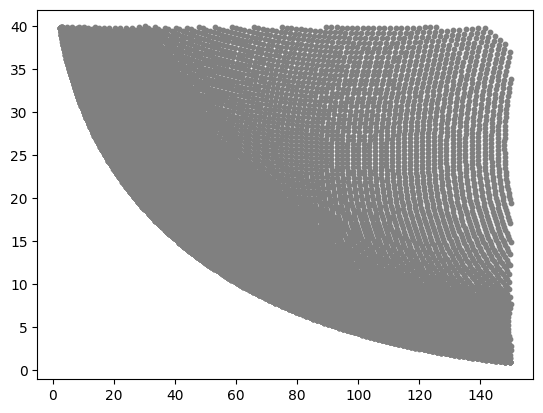

In [6]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.scatter(pf[:,0],pf[:,1],s=10,c='gray',label="Pareto front")
plt.show()

In [65]:
from torch import Tensor
import math
def ode_solve(z0, t0, t1, f):
    """
    Simplest RK4 ODE initial value solver
    """
    h_max = 0.00001
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())
    # print(n_steps)
    # n_steps = 100
    h = (t1 - t0)/n_steps
    t = t0
    z = z0
#     print(n_steps)
    # h = torch.tensor([0.0001])
    # print(h)
    n_steps = 10
    for i_step in range(n_steps):
        k1 = h*f(z,t)
        k2 = h * (f((z+h/2),t))
        k3 = h * (f((z+h/2),t))
        k4 = h * (f((z+h),t))
        k = (1/6)*(k1+2*k2+2*k3+k4)
        z = z + k      
    return z

class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            # print("check z_0:", z0.shape)
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                # print(z0)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # grad method automatically sums gradients for batch items, we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]
def sign(g):
    if g>0:
        return torch.tensor([1])
    elif g<0:
        return torch.tensor([0])
    else:
        p = torch.rand(1)
        return p
import autograd.numpy as np1
from autograd import grad
class TestODEF(ODEF):
    def __init__(self, A, B, x0,s,r):
        super(TestODEF, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
        self.x0 = nn.Parameter(x0)
        self.s = s
        self.r =r
    def forward(self, x, t):
        # print(x)
        J = torch.tensor([sign(g1(x)).item(),sign(g2(x)).item(),sign(g3(x)).item(),sign(g4(x)).item(),\
                          sign(g5(x)).item(),sign(g6(x)).item(),sign(g7(x)).item(),sign(g8(x)).item()\
                            ,sign(g9(x)).item(),sign(g10(x)).item()])
        c = torch.prod(1-J)
        z = x.detach().cpu().numpy()
        grad_f = grad(self.s)(z,self.r)
        # grad_f = grad(f)(z)
        grad_g1 = grad(g1)(z)
        grad_g2 = grad(g2)(z)
        grad_g3 = grad(g3)(z)
        grad_g4 = grad(g4)(z)
        grad_g5 = grad(g5)(z)
        grad_g6 = grad(g6)(z)
        grad_g7 = grad(g7)(z)
        grad_g8 = grad(g8)(z)
        grad_g9 = grad(g9)(z)
        grad_g10 = grad(g10)(z)
#         print(grad_f,grad_g1,grad_g2)
        dxdt = -c*torch.tensor(grad_f) - (sign(g1(x))*torch.tensor(grad_g1) + sign(g2(x))*torch.tensor(grad_g2) + sign(g3(x))*torch.tensor(grad_g3)+ sign(g4(x))*torch.tensor(grad_g4)+ sign(g5(x))*torch.tensor(grad_g5) \
                                          + sign(g6(x))*torch.tensor(grad_g6)+ sign(g7(x))*torch.tensor(grad_g7)+ sign(g8(x))*torch.tensor(grad_g8)+ sign(g9(x))*torch.tensor(grad_g9)+ sign(g10(x))*torch.tensor(grad_g10)) #- (2*sign(g3(x)) - 1)*torch.tensor([[2.,4.,1.,0.]])
        # print(c,grad_f,grad_g1,grad_g2,grad_g3,grad_g4,grad_g5)
        #print("dx/dt: ",dxdt)
        return dxdt


In [8]:
class NNODEF(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim+1, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        #self.lin21 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)
        #self.elu = nn.ReLU(inplace=True)
  

    def forward(self, x, t):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)

        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        #h = self.elu(self.lin21(h))
        out = self.lin3(h)

        return out
class Hypernet_trans(nn.Module):
    def __init__(self, ray_hidden_dim=32, out_dim=2, target_hidden_dim=15, n_hidden=1, n_tasks=2):
        super().__init__()
        self.n_hidden = n_hidden
        self.n_tasks = n_tasks

        if self.n_tasks == 2:
            self.embedding_layer1 =  nn.Sequential(nn.Linear(1, ray_hidden_dim),nn.ReLU(inplace=True))
            self.embedding_layer2 =  nn.Sequential(nn.Linear(1, ray_hidden_dim),nn.ReLU(inplace=True))
        else:
            self.embedding_layer1 =  nn.Sequential(nn.Linear(1, ray_hidden_dim),nn.ReLU(inplace=True))
            self.embedding_layer2 =  nn.Sequential(nn.Linear(1, ray_hidden_dim),nn.ReLU(inplace=True))
            self.embedding_layer3 =  nn.Sequential(nn.Linear(1, ray_hidden_dim),nn.ReLU(inplace=True))
            
        self.output_layer =  nn.Linear(ray_hidden_dim, out_dim)
        self.attention = nn.MultiheadAttention(embed_dim=ray_hidden_dim, num_heads=2)
        self.ffn1 = nn.Linear(ray_hidden_dim,ray_hidden_dim)
        self.ffn2 = nn.Linear(ray_hidden_dim, ray_hidden_dim)
        # self.feature = ode

    def forward(self, ray):
#         ray = ray.unsqueeze(0)
        if self.n_tasks == 2: 
#             x = torch.stack((self.embedding_layer1(ray[:,0].unsqueeze(1)),self.embedding_layer2(ray[:,1].unsqueeze(1))))
            x = torch.stack((self.embedding_layer1(ray[:,0]),self.embedding_layer2(ray[:,1])))
        else:
            x = torch.stack((self.embedding_layer1(ray[:,0].unsqueeze(1)),self.embedding_layer2(ray[:,1].unsqueeze(1)),self.embedding_layer3(ray[:,2].unsqueeze(1))))
        x_ = x
                
        x,_ = self.attention(x,x,x)
        x = x + x_
        x_ = x
        x = self.ffn1(x)
        x = F.relu(x)
        x = self.ffn2(x)
        x = x + x_
        x = self.output_layer(x)
#         print(x.shape)
        x = torch.mean(x,dim=0) 
        # print(x)
        # x = x.unsqueeze(0)
        x = x.unsqueeze(0)
#         print(t.shape,x.shape)
        # print(x.shape)
        # x = self.feature(x,t,return_whole_sequence=True) 
#         print(x)
        return x

In [90]:
hnet = Hypernet_trans(ray_hidden_dim=16,out_dim=4)
optimizer = torch.optim.Adam(hnet.parameters(), lr = 0.001) 
alpha_r = 0.6
ray_train = []
for epoch in tqdm(range(20000)):
    
    hnet.train()
    optimizer.zero_grad()
    ray = torch.from_numpy(
        np.random.dirichlet((alpha_r, alpha_r), 1).astype(np.float32).flatten()
        ).unsqueeze(0)
    
    ray_train.append(ray)
    output = hnet(ray)
    # print(output)
    # output = F.relu(output)   
    # print(output)
    ray_cs = 1/ray
    ray = ray.squeeze(0)
    obj_values = [f1(output),f2(output)]
    losses = torch.stack(obj_values)
    # losses = torch.stack(obj_values)
    # print(losses.shape,ray.shape)
    # print((losses*ray).shape)
    # print((output - 1))
    loss= torch.max(losses*ray) #+ 0.5*torch.sum(1-output)
    # mu = 100
    # loss = mu*torch.log(torch.sum(torch.exp(ray*(losses)/mu)))
    # print(loss)
    # loss = CS_func.chebyshev_function(c)
    loss.backward()
    optimizer.step()
    #mp = []

torch.save(hnet.state_dict(),("/Users/tuantran/Documents/tuan/Multi_task_learning/HPN-CSF/hnet.pth"))

100%|██████████| 20000/20000 [00:16<00:00, 1214.79it/s]


In [91]:
import time
hnet.eval()
tmp = []
x0 = []
x_target = []
t_max = 4
n_points = 10
def s(x,r):
    return np1.max(np.array([r[0]*f1(x),r[1]*f2(x)]))
index_np = np.arange(0, n_points, 1)
index_np = np.hstack([index_np[:, None]])
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]])
t1 = time.time()
for r in test_rays:
    r = r/(r.sum())
    ray_t = torch.tensor(r.tolist())
    F_ = np.max((ray_t.detach().cpu().numpy())*(pf),axis = 1)
    # mu = 100
    # # print(np.exp(ray_t.detach().cpu().numpy()*(pf)))
    # F_ = mu*np.log(np.sum(np.exp(ray_t.detach().cpu().numpy()*(pf)/mu),axis=1))
    y_test,sol_test= pf[F_.argmin(), :],sols[F_.argmin(), :,:]
    func1 = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]),s,ray_t.detach().cpu().numpy())
    ode_true = NeuralODE(func1)
    ray_t = ray_t.unsqueeze(0)
    # print(ray_t)
    output = hnet(ray_t)
    
    times1 = torch.from_numpy(times_np[:, :, None]).to(output)
    obs = ode_true(output, times1, return_whole_sequence=True).detach()
    obj1 = [f1(obs[-1]),f2(obs[-1])]
    obj1 = torch.stack(obj1).detach().cpu().numpy()
    err = np.sum(np.abs(obj1-y_test))
    print(obj1,y_test)
    tmp.append(err)
t2 = time.time()
print("ERR_test: ",np.mean(np.array(tmp)))
print("Run time: ",t2-t1)

[ 3.553461 37.559517] [ 3.65230095 37.39956172]
[ 5.2461042 35.116024 ] [ 5.55961367 34.72323675]
[ 6.8579454 33.19728  ] [ 7.15850986 32.87070855]
[ 8.372425 31.633121] [ 8.58696534 31.42602062]
[ 9.88331  30.241219] [10.14528042 30.01379758]
[11.386251 28.986494] [11.40329519 28.97694992]
[12.883056 27.840782] [13.18886454 27.62154046]
[14.372644 26.786015] [14.6092038  26.62527392]
[15.717001 25.896503] [16.1107053  25.64929795]
[17.117876 25.024162] [17.14958201 25.00811622]
[18.70082  24.097065] [18.76471066 24.06054703]
[20.342445 23.193476] [20.46100154 23.1332684 ]
[22.062695 22.302351] [22.22222222 22.22222222]
[23.881126 21.415255] [24.06460515 21.3314666 ]
[25.84433  20.513733] [25.97191786 20.45694343]
[27.966248 19.597584] [27.96039283 19.60271082]
[30.282055 18.65906 ] [30.01379758 18.76471066]
[32.84266  17.687433] [32.14836458 17.94700106]
[35.820007 16.634789] [35.10267024 16.88377567]
[39.37328 15.47374] [38.97410924 15.59938317]
[43.53972  14.226936] [42.22059898 14.

In [92]:
import time
hnet.eval()
tmp = []
x0 = []
x_target = []
t_max = 4
n_points = 10
def s(x,r):
    return np1.max(np.array([r[0]*f1(x),r[1]*f2(x)]))
index_np = np.arange(0, n_points, 1)
index_np = np.hstack([index_np[:, None]])
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]])
t1 = time.time()
for r in test_rays:
    r = r/(r.sum())
    ray_t = torch.tensor(r.tolist())
    F_ = np.max((ray_t.detach().cpu().numpy())*(pf),axis = 1)
    # mu = 100
    # # print(np.exp(ray_t.detach().cpu().numpy()*(pf)))
    # F_ = mu*np.log(np.sum(np.exp(ray_t.detach().cpu().numpy()*(pf)/mu),axis=1))
    y_test,sol_test= pf[F_.argmin(), :],sols[F_.argmin(), :,:]
    # func1 = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]),s,ray_t.detach().cpu().numpy())
    # ode_true = NeuralODE(func1)
    ray_t = ray_t.unsqueeze(0)
    # print(ray_t)
    output = hnet(ray_t)
    # times1 = torch.from_numpy(times_np[:, :, None]).to(output)
    # obs = ode_true(output, times1, return_whole_sequence=True).detach()
    obj1 = [f1(output),f2(output)]
    obj1 = torch.stack(obj1).detach().cpu().numpy()
    err = np.sum(np.abs(obj1-y_test))
    print(obj1,y_test)
    tmp.append(err)
t2 = time.time()
print("ERR_test: ",np.mean(np.array(tmp)))
print("Run time: ",t2-t1)

[ 3.521383 37.611813] [ 3.65230095 37.39956172]
[ 5.2238493 35.14485  ] [ 5.55961367 34.72323675]
[ 6.8480234 33.208202 ] [ 7.15850986 32.87070855]
[ 8.375854 31.629791] [ 8.58696534 31.42602062]
[ 9.901248 30.225542] [10.14528042 30.01379758]
[11.41958  28.959934] [11.40329519 28.97694992]
[12.9324875 27.804497 ] [13.18886454 27.62154046]
[14.438726 26.740982] [14.6092038  26.62527392]
[15.798545 25.844269] [16.1107053  25.64929795]
[17.215944 24.965002] [17.14958201 25.00811622]
[18.817987 24.03072 ] [18.76471066 24.06054703]
[20.479836 23.120308] [20.46100154 23.1332684 ]
[22.221693 22.222637] [22.22222222 22.22222222]
[24.063358 21.329224] [24.06460515 21.3314666 ]
[26.052067 20.421486] [25.97191786 20.45694343]
[28.201965 19.499252] [27.96039283 19.60271082]
[30.548763 18.554756] [30.01379758 18.76471066]
[33.14411  17.577246] [32.14836458 17.94700106]
[36.162422 16.518599] [35.10267024 16.88377567]
[39.76529  15.351412] [38.97410924 15.59938317]
[43.9907   14.098665] [42.22059898

In [124]:
class NNODEF_trans(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF_trans, self).__init__()
        self.time_invariant = time_invariant

        self.embedding_layer1 =  nn.Sequential(nn.Linear(1, hid_dim),nn.ReLU(inplace=True))
        self.embedding_layer2 =  nn.Sequential(nn.Linear(1, hid_dim),nn.ReLU(inplace=True))
        self.embedding_layer3 =  nn.Sequential(nn.Linear(1, hid_dim),nn.ReLU(inplace=True))
        self.embedding_layer4 =  nn.Sequential(nn.Linear(1, hid_dim),nn.ReLU(inplace=True))
            
        self.output_layer =  nn.Linear(hid_dim, in_dim)
        self.attention = nn.MultiheadAttention(embed_dim=hid_dim, num_heads=2)
        self.ffn1 = nn.Linear(hid_dim,hid_dim)
        self.ffn2 = nn.Linear(hid_dim, hid_dim)


    def forward(self, x, t):
        #print(x.shape,t.shape,self.time_invariant)
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)
        # print(x.shape)
#         x = torch.stack((self.embedding_layer1(x[:,0]),self.embedding_layer2(x[:,1]),self.embedding_layer3(x[:,2])))
        x = torch.stack((self.embedding_layer1(x[:,:,0]),self.embedding_layer2(x[:,:,1]),self.embedding_layer3(x[:,:,2]),self.embedding_layer4(x[:,:,3])))
        x_ = x 
        x,_ = self.attention(x,x,x)
        x = x + x_
        x_ = x
        x = self.ffn1(x)
        x = F.relu(x)
        x = self.ffn2(x)
        x = x + x_
        x = self.output_layer(x)
        x = torch.mean(x,dim=0)
        # print(x.shape)
        x = x.unsqueeze(1)

        return x
class NNODEF(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim+1, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        #self.lin21 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)
        #self.elu = nn.ReLU(inplace=True)
  

    def forward(self, x, t):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)

        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        #h = self.elu(self.lin21(h))
        out = self.lin3(h)

        return out

In [125]:
def plot_trajectories(obs_true=None,obs_predict=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    ig, ax = plt.subplots()
    ax.scatter(obs_true[:,0],obs_true[:,1],s=20,c='gray',label="PF_true",marker='X')
    ax.scatter(obs_predict[:,0],obs_predict[:,1],s=20,c='red',label="PF_predict",marker='D')
    plt.legend()
#     ax.plot(pf_tmp2[:,0],pf_tmp2[:,1],c='green',label="PF_hypernet")
#     plt.gca().set_xlim(46, 48)  # Set x-axis limits
#     plt.gca().set_ylim(13, 14)  # Set y-axis limits
    plt.show()
    # if save is not None:
    #     plt.savefig(save)
#     plt.show()

In [133]:
# def l1(x):
#     return (x[:,0,0] + 1)/(-x[:,0,0]**2 + 3*x[:,0,0] - x[:,0,1]**2 + 3*x[:,0,1] +3.5)
# def l2(x):
#     return (x[:,0,0]**2 - 2*x[:,0,0] + x[:,0,1]**2 - 8*x[:,0,1] + 20)/x[:,0,1]
from IPython.display import clear_output
best_err = 1000
def l1(x):
    return 4*x[:,:,0]**2 + 4*x[:,:,1]**2 
def l2(x):
    return (x[:,:,0]-5)**2 + (x[:,:,1]-5)**2 
sol = []
alpha_r = 0.6
func = NNODEF(4, 200, time_invariant=True)
# func = NNODEF_trans(4, 50, time_invariant=True)
ode_trained = NeuralODE(func)
# model = Hypernet_trans(ode = ode_trained,ray_hidden_dim=32)#Hypernet_trans(ode = ode_trained,ray_hidden_dim=16) #Hypernet_mlp(ode = ode_trained)
# ode_trained = ode_trained.cuda()
optimizer = torch.optim.Adam(ode_trained.parameters(), lr = 0.1) 
def s(x,r):
    return np1.max(np.array([r[0]*f1(x),r[1]*f2(x)]))
def create_dt(hnet,batch,ray_train):
    hnet.eval()
    # ran_ind = torch.randint(0,len(ray_train),(batch,))
    # # print(ran_ind)
    # # print(ray_train[[0,1]])
    # print(ray_train)
    # ray_in = ray_train[ran_ind]
    # Flatten the list of tensors into a single list
    flattened_list = [item for sublist in ray_train for item in sublist]

    # Randomly choose 16 elements from the flattened list
    ray_in = random.sample(flattened_list, batch)

    x0 = []
    x_target = []
    t_max = 4
    n_points = 10

    index_np = np.arange(0, n_points, 1)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    # #output = model(ray)
    # output = ray.unsqueeze(0)
    # #print("z0: ",output)
    # z0 = Variable(output)
    
    for r in ray_in:
        F_ = np.max((r.detach().cpu().numpy())*(pf),axis = 1)
        y_target,sol_target = pf[F_.argmin(), :],sols[F_.argmin(), :,:]
        func1 = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]),s,r.detach().cpu().numpy())
        ode_true = NeuralODE(func1)
        r = r.unsqueeze(0)
        output = hnet(r)
        x0.append(output)
        times1 = torch.from_numpy(times_np[:, :, None]).to(output)
        obs = ode_true(output, times1, return_whole_sequence=True).detach()
        # print(obs,sol_target)
        x_target.append(obs)
        # print(sol_target,obs)

    return torch.stack(ray_in,dim=0),torch.stack(x0,dim=0),torch.stack(x_target,dim=0),times1
for e in range(100):
    # print("Epoch: ",e)
    ode_trained.train()
    optimizer.zero_grad()
    ray_in,x0,x_target,times1 = create_dt(hnet,8,ray_train)
    # print("x0:",x0.shape,times1.shape)
    # x0 = x0
    # x_target = x_target.cuda()
    obs_train = ode_trained(x0,times1,return_whole_sequence=True)
    obs_train = obs_train.permute(1,0,2,3)
    # print(ray_in[0],x0[0],x_target[0])
    # print("x0:", x0)
    loss1 = [l1(obs_train[:,-1,:,:]),l2(obs_train[:,-1,:,:])]
    loss1 = torch.stack(loss1)
    loss2 = [l1(x_target[:,-1,:,:]),l2(x_target[:,-1,:,:])]
    loss2 = torch.stack(loss2)
    # print("x_pred: ",obs_train[:,-1,:,:])
    # print(loss1.T)
    # print("x_target: ",x_target[:,-1,:,:])
    # print(loss2.T)
    # print(obs_train.shape,x_target.shape)
    # loss = F.mse_loss(obs_train[:,-1,:,:], x_target[:,-1,:,:])
    # loss = F.mse_loss(obs_train, x_target)
    # print(torch.abs(obs_train[:,-1,:,:] - x_target[:,-1,:,:]))
    loss = torch.mean(torch.abs(obs_train - x_target))
    # print(loss)

    loss.backward()
    optimizer.step()
    # print("Loss: ",loss)
    t1 = time.time()
    hnet.eval()
    ode_trained.eval()
    tmp = []
    pf_pred = []
    pf_true = []
    for r in test_rays:
        r = r/(r.sum())
        ray_t = torch.tensor(r.tolist()).unsqueeze(0)
        F_ = np.max((ray_t.detach().cpu().numpy())*(pf),axis = 1)
        y_test,sol_test= pf[F_.argmin(), :],sols[F_.argmin(), :,:]
        pf_true.append(y_test)
        x0_test = hnet(ray_t)
        # print(times1.shape)
        # x0_test = x0_test.cuda()
#         x_target = x_target.cuda()
        z_test = ode_trained(x0_test.unsqueeze(0),times1, return_whole_sequence=True)
        # print(z_test[-1].shape)
        obj1 = [l1(z_test[-1]).item(),l2(z_test[-1]).item()]
        pf_pred.append(obj1)
        # print(obj1)
        obj1 = np.array(obj1)
        
        # print(ray_t,obj1,y_test)
        # print(obj1)
        # print(y_test)
        # print("c:",np.abs(obj1-y_test))
        err = np.sum(np.abs(obj1-y_test))
        tmp.append(err)
    t2 = time.time()
    err_e = np.mean(np.array(tmp))
    # print(err_e)
    # plot_trajectories(obs_true=np.array(pf_true),obs_predict=np.array(pf_pred), save=f"/Users/tuantran/Documents/tuan/Multi_task_learning/HPN-CSF/{e}.png", figsize=(16, 8))
    #clear_output(wait=True)
    if err_e < best_err:
        best_err = err_e

        print("ERR_test: ",best_err)
        # print("Run time: ",t2-t1)
        # plot_trajectories(obs_true=np.array(pf_true),obs_predict=np.array(pf_pred), save=f"/Users/tuantran/Documents/tuan/Multi_task_learning/HPN-CSF/{e}.png", figsize=(16, 8))
        # clear_output(wait=True)
        torch.save(ode_trained.state_dict(), '/Users/tuantran/Documents/tuan/Multi_task_learning/HPN-CSF/best_model_nnode.pth')



ERR_test:  0.7299401757802377
ERR_test:  0.5343993404760574


# Hypernet + NNODE

[ 3.58882284 37.50178146] [ 3.65230095 37.39956172]
[ 5.2590971  35.09894943] [ 5.55961367 34.72323675]
[ 6.84705973 33.20902252] [ 7.15850986 32.87070855]
[ 8.33601379 31.6683445 ] [ 8.58696534 31.42602062]
[ 9.81955242 30.29690933] [10.14528042 30.01379758]
[11.29383659 29.06024551] [11.40329519 28.97694992]
[12.76105881 27.93058014] [13.18886454 27.62154046]
[14.22060585 26.89002609] [14.6092038  26.62527392]
[15.53827095 26.01147079] [16.1107053  25.64929795]
[16.9114151  25.14928055] [17.14958201 25.00811622]
[18.46343994 24.23221207] [18.76471066 24.06054703]
[20.07275391 23.33800125] [20.46100154 23.1332684 ]
[21.75905228 22.45566177] [22.22222222 22.22222222]
[23.54149055 21.57685852] [24.06460515 21.3314666 ]
[25.46588516 20.68322372] [25.97191786 20.45694343]
[27.54587936 19.77455902] [27.96039283 19.60271082]
[29.81592941 18.84315491] [30.01379758 18.76471066]
[32.3259964  17.87828255] [32.14836458 17.94700106]
[35.24523163 16.83205032] [35.10267024 16.88377567]
[38.72991943

<Figure size 1600x800 with 0 Axes>

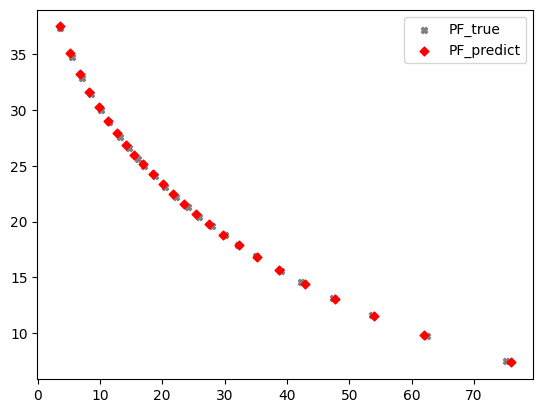

In [150]:
t1 = time.time()
ode_trained.load_state_dict(torch.load("/Users/tuantran/Documents/tuan/Multi_task_learning/HPN-CSF/best_model_nnode.pth"))
hnet.eval()
ode_trained.eval()
tmp = []
pf_pred = []
pf_true = []
for r in test_rays:
    r = r/(r.sum())
    ray_t = torch.tensor(r.tolist()).unsqueeze(0)
    F_ = np.max((ray_t.detach().cpu().numpy())*(pf),axis = 1)
    y_test,sol_test= pf[F_.argmin(), :],sols[F_.argmin(), :,:]
    pf_true.append(y_test)
    x0_test = hnet(ray_t)
    # print(times1.shape)
    # x0_test = x0_test.cuda()
#         x_target = x_target.cuda()
    z_test = ode_trained(x0_test.unsqueeze(0),times1, return_whole_sequence=True)
    # print(z_test[-1].shape)
    obj1 = [l1(z_test[-1]).item(),l2(z_test[-1]).item()]
    pf_pred.append(obj1)
    # print(obj1)
    obj1 = np.array(obj1)
    
    print(obj1,y_test)
    # print(obj1)
    # print(y_test)
    # print("c:",np.abs(obj1-y_test))
    err = np.sum(np.abs(obj1-y_test))
    tmp.append(err)
t2 = time.time()
err_e = np.mean(np.array(tmp))
print("Run time: ",t2-t1)
print("Error: ",err_e)
plot_trajectories(obs_true=np.array(pf_true),obs_predict=np.array(pf_pred), save=f"/Users/tuantran/Documents/tuan/Multi_task_learning/HPN-CSF/{e}.png", figsize=(16, 8))

# Hypernet + ODE

[ 3.553461 37.559517] [ 3.65230095 37.39956172]
[ 5.2461042 35.116024 ] [ 5.55961367 34.72323675]
[ 6.8579454 33.19728  ] [ 7.15850986 32.87070855]
[ 8.372425 31.633121] [ 8.58696534 31.42602062]
[ 9.88331  30.241219] [10.14528042 30.01379758]
[11.386251 28.986494] [11.40329519 28.97694992]
[12.883056 27.840782] [13.18886454 27.62154046]
[14.372644 26.786015] [14.6092038  26.62527392]
[15.717001 25.896503] [16.1107053  25.64929795]
[17.117876 25.024162] [17.14958201 25.00811622]
[18.70082  24.097065] [18.76471066 24.06054703]
[20.342445 23.193476] [20.46100154 23.1332684 ]
[22.062695 22.302351] [22.22222222 22.22222222]
[23.881126 21.415255] [24.06460515 21.3314666 ]
[25.84433  20.513733] [25.97191786 20.45694343]
[27.966248 19.597584] [27.96039283 19.60271082]
[30.282055 18.65906 ] [30.01379758 18.76471066]
[32.84266  17.687433] [32.14836458 17.94700106]
[35.820007 16.634789] [35.10267024 16.88377567]
[39.37328 15.47374] [38.97410924 15.59938317]
[43.53972  14.226936] [42.22059898 14.

<Figure size 1600x800 with 0 Axes>

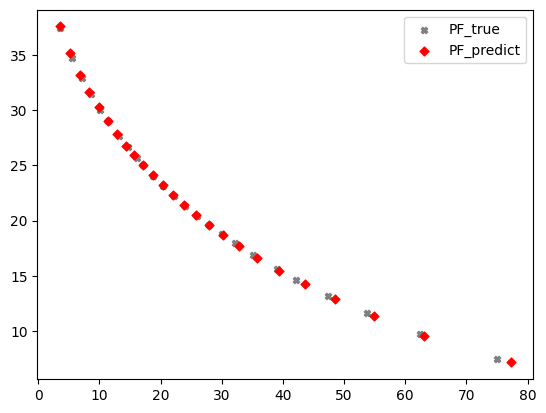

In [141]:
import time
hnet.eval()
tmp = []
x0 = []
x_target = []
t_max = 4
n_points = 10
def s(x,r):
    return np1.max(np.array([r[0]*f1(x),r[1]*f2(x)]))
index_np = np.arange(0, n_points, 1)
index_np = np.hstack([index_np[:, None]])
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]])
t1 = time.time()
pf_pred = []
pf_true = []
for r in test_rays:
    r = r/(r.sum())
    ray_t = torch.tensor(r.tolist())
    F_ = np.max((ray_t.detach().cpu().numpy())*(pf),axis = 1)
    y_test,sol_test= pf[F_.argmin(), :],sols[F_.argmin(), :,:]
    pf_true.append(y_test)
    func1 = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]),s,ray_t.detach().cpu().numpy())
    ode_true = NeuralODE(func1)
    ray_t = ray_t.unsqueeze(0)
    # print(ray_t)
    output = hnet(ray_t)
    
    times1 = torch.from_numpy(times_np[:, :, None]).to(output)
    obs = ode_true(output, times1, return_whole_sequence=True).detach()
    obj1 = [f1(obs[-1]),f2(obs[-1])]
    pf_pred.append(obj1)
    obj1 = torch.stack(obj1).detach().cpu().numpy()
    err = np.sum(np.abs(obj1-y_test))
    print(obj1,y_test)
    tmp.append(err)
t2 = time.time()
print("ERR_test: ",np.mean(np.array(tmp)))
print("Run time: ",t2-t1)
plot_trajectories(obs_true=np.array(pf_true),obs_predict=np.array(pf_pred), save=f"/Users/tuantran/Documents/tuan/Multi_task_learning/HPN-CSF/{e}.png", figsize=(16, 8))

# Hypernet

[ 3.521383 37.611813] [ 3.65230095 37.39956172]
[ 5.2238493 35.14485  ] [ 5.55961367 34.72323675]
[ 6.8480234 33.208202 ] [ 7.15850986 32.87070855]
[ 8.375854 31.629791] [ 8.58696534 31.42602062]
[ 9.901248 30.225542] [10.14528042 30.01379758]
[11.41958  28.959934] [11.40329519 28.97694992]
[12.9324875 27.804497 ] [13.18886454 27.62154046]
[14.438726 26.740982] [14.6092038  26.62527392]
[15.798545 25.844269] [16.1107053  25.64929795]
[17.215944 24.965002] [17.14958201 25.00811622]
[18.817987 24.03072 ] [18.76471066 24.06054703]
[20.479836 23.120308] [20.46100154 23.1332684 ]
[22.221693 22.222637] [22.22222222 22.22222222]
[24.063358 21.329224] [24.06460515 21.3314666 ]
[26.052067 20.421486] [25.97191786 20.45694343]
[28.201965 19.499252] [27.96039283 19.60271082]
[30.548763 18.554756] [30.01379758 18.76471066]
[33.14411  17.577246] [32.14836458 17.94700106]
[36.162422 16.518599] [35.10267024 16.88377567]
[39.76529  15.351412] [38.97410924 15.59938317]
[43.9907   14.098665] [42.22059898

<Figure size 1600x800 with 0 Axes>

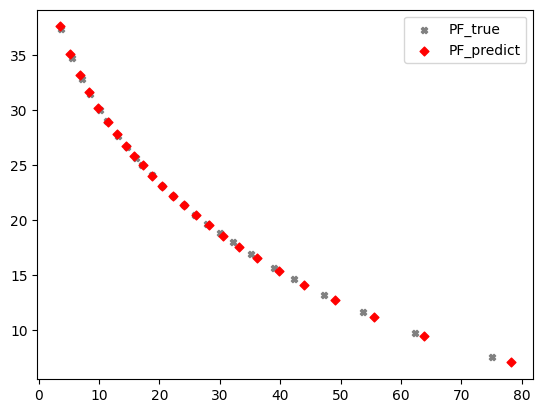

In [142]:
import time
hnet.eval()
tmp = []
x0 = []
x_target = []
t_max = 4
n_points = 10
def s(x,r):
    return np1.max(np.array([r[0]*f1(x),r[1]*f2(x)]))
index_np = np.arange(0, n_points, 1)
index_np = np.hstack([index_np[:, None]])
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]])
t1 = time.time()
pf_pred = []
pf_true = []
for r in test_rays:
    r = r/(r.sum())
    ray_t = torch.tensor(r.tolist())
    F_ = np.max((ray_t.detach().cpu().numpy())*(pf),axis = 1)
    y_test,sol_test= pf[F_.argmin(), :],sols[F_.argmin(), :,:]
    pf_true.append(y_test)
    # func1 = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]),s,ray_t.detach().cpu().numpy())
    # ode_true = NeuralODE(func1)
    ray_t = ray_t.unsqueeze(0)
    # print(ray_t)
    output = hnet(ray_t)
    # times1 = torch.from_numpy(times_np[:, :, None]).to(output)
    # obs = ode_true(output, times1, return_whole_sequence=True).detach()
    obj1 = [f1(output),f2(output)]
    
    obj1 = torch.stack(obj1).detach().cpu().numpy()
    pf_pred.append(obj1)
    err = np.sum(np.abs(obj1-y_test))
    print(obj1,y_test)
    tmp.append(err)
t2 = time.time()
print("ERR_test: ",np.mean(np.array(tmp)))
print("Run time: ",t2-t1)
plot_trajectories(obs_true=np.array(pf_true),obs_predict=np.array(pf_pred), save=f"/Users/tuantran/Documents/tuan/Multi_task_learning/HPN-CSF/{e}.png", figsize=(16, 8))

# ODE

[ 2.8339589 40.348595 ] [ 3.65230095 37.39956172]
[ 3.30119  38.709633] [ 5.55961367 34.72323675]
[ 4.7970824 35.71231  ] [ 7.15850986 32.87070855]
[ 3.2263436 38.48931  ] [ 8.58696534 31.42602062]
[ 3.2973537 39.09765  ] [10.14528042 30.01379758]
[ 3.6091132 37.729744 ] [11.40329519 28.97694992]
[ 0.6014975 44.76241  ] [13.18886454 27.62154046]
[ 3.8021579 37.162666 ] [14.6092038  26.62527392]
[ 3.7441554 37.272675 ] [16.1107053  25.64929795]
[ 1.3586096 42.82618  ] [17.14958201 25.00811622]
[ 0.82737803 44.7936    ] [18.76471066 24.06054703]
[3.2438315e-02 4.8767998e+01] [20.46100154 23.1332684 ]
[ 0.8317942 45.129425 ] [22.22222222 22.22222222]
[ 0.578608 45.49991 ] [24.06460515 21.3314666 ]
[ 0.39708614 46.122574  ] [25.97191786 20.45694343]
[ 0.27437884 46.623703  ] [27.96039283 19.60271082]
[ 2.6040545 42.35431  ] [30.01379758 18.76471066]
[ 6.2778516 33.876644 ] [32.14836458 17.94700106]
[ 2.6052704 39.49533  ] [35.10267024 16.88377567]
[ 2.6009247 41.477898 ] [38.97410924 15.59

<Figure size 1600x800 with 0 Axes>

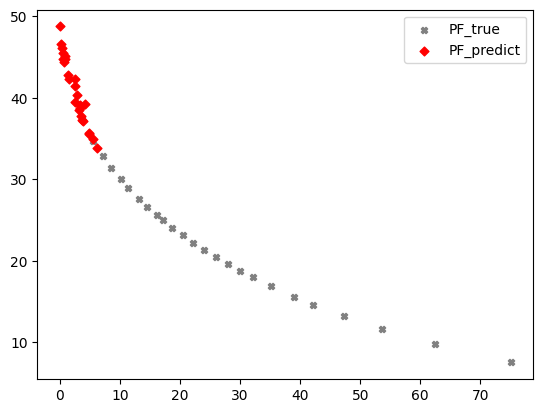

In [149]:
import time
hnet.eval()
tmp = []
x0 = []
x_target = []
t_max = 4
n_points = 10
def s(x,r):
    return np1.max(np.array([r[0]*f1(x),r[1]*f2(x)]))
index_np = np.arange(0, n_points, 1)
index_np = np.hstack([index_np[:, None]])
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]])
t1 = time.time()
pf_pred = []
pf_true = []
for r in test_rays:
    r = r/(r.sum())
    ray_t = torch.tensor(r.tolist())
    F_ = np.max((ray_t.detach().cpu().numpy())*(pf),axis = 1)
    y_test,sol_test= pf[F_.argmin(), :],sols[F_.argmin(), :,:]
    pf_true.append(y_test)
    func1 = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]),s,ray_t.detach().cpu().numpy())
    ode_true = NeuralODE(func1)
    ray_t = ray_t.unsqueeze(0)
    output = torch.rand(1,4)
    # print(output)
    times1 = torch.from_numpy(times_np[:, :, None]).to(output)
    obs = ode_true(output, times1, return_whole_sequence=True).detach()
    obj1 = [f1(obs[-1]),f2(obs[-1])]
    pf_pred.append(obj1)
    obj1 = torch.stack(obj1).detach().cpu().numpy()
    err = np.sum(np.abs(obj1-y_test))
    print(obj1,y_test)
    tmp.append(err)
t2 = time.time()
print("ERR_test: ",np.mean(np.array(tmp)))
print("Run time: ",t2-t1)
plot_trajectories(obs_true=np.array(pf_true),obs_predict=np.array(pf_pred), save=f"/Users/tuantran/Documents/tuan/Multi_task_learning/HPN-CSF/{e}.png", figsize=(16, 8))